<a href="https://colab.research.google.com/github/flowergum/Colorization/blob/main/Color_small.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Восстановление цвета чёрно-белых изображений

### Импорты и настройки

In [ ]:
import os
import shutil
import tensorflow as tf
import tensorboard as tb
import torch
import math
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from torch.nn import RNN, LSTM
import torchvision
from torchvision.datasets import MNIST, CIFAR10
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch.nn import init
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, \
                                    Dense, \
                                    MaxPool2D,\
                                    Dropout, \
                                    Flatten, \
                                    BatchNormalization, InputLayer, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from skimage.color import rgb2lab, lab2rgb
from skimage.io import imsave
from google.colab import files
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
import glob

import zipfile
import os
from PIL import Image
import matplotlib.pyplot as plt

import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
!nvidia-smi

Thu May 13 12:43:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    24W /  75W |    199MiB /  7611MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Загрузка датасета

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#скачиваем и распаковываем .zip файл с изображениями для train, делать 1 раз
z = zipfile.ZipFile('/content/drive/MyDrive/Colorization/zip/traain.zip', 'r')
img = z.extractall()

In [ ]:
#скачиваем и распаковываем .zip файл с изображениями для test, делать 1 раз
z = zipfile.ZipFile('/content/drive/MyDrive/Colorization/zip/teest.zip', 'r')
img = z.extractall()

### Создание генератора датасета

In [ ]:
def batch_gen(path):
    fileList = os.listdir(path)
    for filepath in fileList:
        img = cv2.imread(path + "/" + filepath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # processed image
        image = Image.fromarray(np.uint8(img)).resize((128, 128))
        image = np.array(image, dtype=float)
        lab = rgb2lab(1.0/255*image)
        X, Y = lab[:,:,0], lab[:,:,1:]/128
        X = X.reshape(image.shape[0], image.shape[1], 1)
        Y = Y.reshape(image.shape[0], image.shape[1], 2)
        yield X, Y                                    #yield -- приостанавливает выполнение, не прерывает. Подробнее в тексте

def dataset_gen(path, epochs, batch_size):
    dataset = tf.data.Dataset.from_generator(lambda: batch_gen(path),
                                             output_types=(tf.float64, tf.float64))  #тут формируем датасет
    #print(dataset.shape)
    dataset = dataset.repeat(epochs)          #повторяем датасет нужное число раз; н-р, epochs = 2: [1, 2, 3] --> [1, 2, 3, 1, 2, 3]
    dataset = dataset.batch(batch_size)       #формирует пакеты по batch_size штук в каждом
    return dataset

def train_gen(path):
    dataset = tf.data.Dataset.from_generator(lambda: batch_gen(path),
                                             output_types=(tf.float64, tf.float64))  #тут формируем датасет
    return dataset

### Создание тестовой выборки

In [ ]:
def processed_image(img):    
  img = np.array(img, dtype=float)
  image = Image.fromarray(np.uint8(img)).resize((128, 128))
  image = np.array(image, dtype=float)   
  size = image.shape
  lab = rgb2lab(1.0/255*image)                
  X, Y = lab[:,:,0], lab[:,:,1:]              
  Y /= 128    


  X = X.reshape(size[0], size[1], 1)
  Y = Y.reshape(size[0], size[1], 2)
  del size
  return X, Y

In [ ]:
#train выборка методами test-выборки
import cv2
x_train = []
y_train = []
#путь к папке с распакованными изображениями
path = '/content/traain'
fileList = os.listdir(path)
j = 0
for i in fileList:
   file_ = cv2.imread(('/content/traain/' + i))
   file_ = cv2.cvtColor(file_, cv2.COLOR_BGR2RGB)
   X, Y = processed_image(file_)
   #print(X.shape)
   if X.shape == (128, 128, 1) and Y.shape == (128, 128, 2):
      x_train.append(X)
      y_train.append(Y)
   else:
      print('xexe')
   j += 1


x_train = np.array(x_train)
y_train = np.array(y_train)
print(x_train.shape, y_train.shape)

In [ ]:
max1 = np.amax(y_train)
min1 = np.amin(y_train)
mean_a = np.mean(y_train[:,:,:,0])
mean_b = np.mean(y_train[:,:,:,1])
std_a = np.std(y_train[:,:,:,0])
std_b = np.std(y_train[:,:,:,1])

In [ ]:
y_train[:,:,:,0] = (y_train[:,:,:,0] - np.mean(y_train[:,:,:,0]))/np.std(y_train[:,:,:,0])
y_train[:,:,:,1] = (y_train[:,:,:,1] - np.mean(y_train[:,:,:,1]))/np.std(y_train[:,:,:,1])

In [ ]:
import cv2
list_x = []
list_y = []
#путь к папке с распакованными изображениями
path = '/content/teest'
fileList = os.listdir(path)
for i in fileList:
   file_ = cv2.imread(('/content/teest/' + i))
   file_ = cv2.cvtColor(file_, cv2.COLOR_BGR2RGB)
   X, Y = processed_image(file_)
   #print(X.shape)
   if X.shape == (128, 128, 1) and Y.shape == (128, 128, 2):
      list_x.append(X)
      list_y.append(Y)
   else:
      print('xexe')

In [ ]:
list_x = np.array(list_x)
list_y = np.array(list_y)
print(list_x.shape, list_y.shape)

(3729, 128, 128, 1) (3729, 128, 128, 2)


In [ ]:
list_y[:,:,:,0] = (list_y[:,:,:,0] - np.mean(list_y[:,:,:,0]))/np.std(list_y[:,:,:,0])
list_y[:,:,:,1] = (list_y[:,:,:,1] - np.mean(list_y[:,:,:,1]))/np.std(list_y[:,:,:,1])

### Создание модели

In [ ]:
model = Sequential()                                                      # Последовательная
model.add(InputLayer(input_shape=(None, None, 1)))                        # Входной слой, подаем на вход яркостную компоненту
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))          # Свертка, 64 фильтра
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
#model.add(UpSampling2D((2, 2))) #Растягивает картинку
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
#model.add(UpSampling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
#model.add(BatchNormalization())
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))

model.compile(optimizer='adam', loss='mse')
#model.summary()

#### Модель 2, для сравнения

In [ ]:
 model2 = Sequential()     #из статьи сравниваю
 model2.add(InputLayer(input_shape=(None, None, 1)))
 model2.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
 model2.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
 model2.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
 model2.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
 model2.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
 model2.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
 model2.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
 model2.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
 model2.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
 model2.add(UpSampling2D((2, 2)))
 model2.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
 model2.add(UpSampling2D((2, 2)))
 model2.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
 model2.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
 model2.add(UpSampling2D((2, 2)))

 #model2.compile(optimizer='adam', loss='mse')

In [ ]:
# history2 = model2.fit(x=x_train, y=y_train, batch_size=100, epochs=35) #всего 55 эпох (55 -- оптимально: размер изображения: 128*128, 2500 картинок на 5 классов)

### Обучение сети

In [ ]:
#model.load_weights("drive/MyDrive/Colorization/weights/4.normal_3_classes_30_epoch_9728_samples.h5")

# Сами разбейте новый объект датасета на тренировочную и тестовую выборку
# history = model.fit(x=x_train1, y=y_train1, batch_size=500, epochs=6, validation_data=(x_test1, y_test1))

In [ ]:
train_path = '/content/traain'
test_path = '/content/teest'

epochs = 15
batch_size = 256
total_items = len(os.listdir(train_path))
num_batches = int(total_items/batch_size)
print(f"batch_size={batch_size}\nnum_batches = {num_batches}\ntotal_samples={num_batches*batch_size}\n{'-'*30}")


dataset = dataset_gen(train_path, epochs, batch_size)

#history = model.fit(x=x_train, y=y_train, batch_size=256, epochs=30, validation_data=(list_x, list_y))
history = model.fit(dataset, steps_per_epoch=num_batches, epochs=epochs, validation_data=(list_x, list_y), verbose=1)

batch_size=256
num_batches = 74
total_samples=18944
------------------------------
Epoch 1/15
74/74 [==============================] - 287s 3s/step - loss: 0.7743 - val_loss: 0.0113
Epoch 2/15
74/74 [==============================] - 245s 3s/step - loss: 0.0111 - val_loss: 0.0101
Epoch 3/15
74/74 [==============================] - 244s 3s/step - loss: 0.0100 - val_loss: 0.0094
Epoch 4/15
74/74 [==============================] - 246s 3s/step - loss: 0.0096 - val_loss: 0.0092
Epoch 5/15
74/74 [==============================] - 244s 3s/step - loss: 0.0093 - val_loss: 0.0090
Epoch 6/15
74/74 [==============================] - 246s 3s/step - loss: 0.0092 - val_loss: 0.0087
Epoch 7/15
74/74 [==============================] - 248s 3s/step - loss: 0.0090 - val_loss: 0.0087
Epoch 8/15
74/74 [==============================] - 252s 3s/step - loss: 0.0090 - val_loss: 0.0086
Epoch 9/15
74/74 [==============================] - 252s 3s/step - loss: 0.0089 - val_loss: 0.0085
Epoch 10/15
74/74 [=======

In [ ]:
model.save_weights("drive/MyDrive/Colorization/weights/Many_classes_15_epoch_18946_samples.h5")

#### Вариант обратного преобразования (не допилен)

In [ ]:
def one_img_to_model(img):
    img = np.array(img, dtype=float)
    lab = rgb2lab(1.0/255*img)
    X, Y = lab[:,:,0], lab[:,:,1:]/128
    X = X.reshape(img.shape[0], img.shape[1], 1)
    X = np.reshape(X, (1, 128, 128, 1))
    return X

In [ ]:
def collect2rgb(l, ab):
    ab *= 128
    lab = np.concatenate((l, ab), axis = 2)
    rgb = lab2rgb(lab)
    return rgb

(128, 128, 1) (128, 128, 2)


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


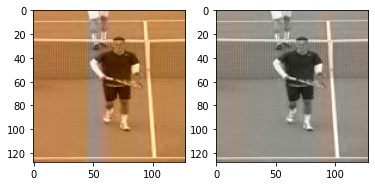

In [ ]:
i = 1234

a = np.reshape((list_x[i]), (1, 128, 128, 1))
y_predict = model.predict(a)
print(list_x[i].shape, list_y[i].shape)
real = collect2rgb(list_x[i], list_y[i])

y = np.reshape((y_predict), (128, 128, 2))
predict = collect2rgb(list_x[i], y)
#print(real)
plt.subplot(1, 2, 1)
plt.imshow(real)
plt.subplot(1, 2, 2)
plt.imshow(predict)

#### Без преобразований функциями


In [ ]:
print('ДО:')
print('max:', max1)
print('min:', min1)
print('ПОСЛЕ:')
print('max:', np.amax(y_train))
print('min:', np.amin(y_train))

In [ ]:
i = 20074
img = Image.open('/content/drive/MyDrive/Colorization/test/' + str(i) + '.jpg')
image = img.resize((1920, 1280))
imag = np.array(image)

#imag = np.array(img)
size = imag.shape 
print(size)

lab = rgb2lab(1.0/255*imag)                
A, Y = lab[:,:,0], lab[:,:,1:]

X = np.reshape((A), (1, size[0], size[1], 1))
print(X.shape)
output = model.predict(X)
print(output.shape)


#output[:,:,:,0] = output[:,:,:,0] * std_a + mean_a
#output[:,:,:,1] = output[:,:,:,1] * std_b + mean_b

output *= (128)
min_vals, max_vals = -128, 127
ab = np.clip(output[0], min_vals, max_vals)

cur = np.zeros((size[0], size[1], 3))
cur[:,:,0] = np.clip(X[0][:,:,0], 0, 100)
cur[:,:,1:] = ab
rgb = lab2rgb(cur)
#rgb[:,:,0] = 
#rgb[:,:,0] = 
#rgb[:,:,0] = 
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(rgb)


# График

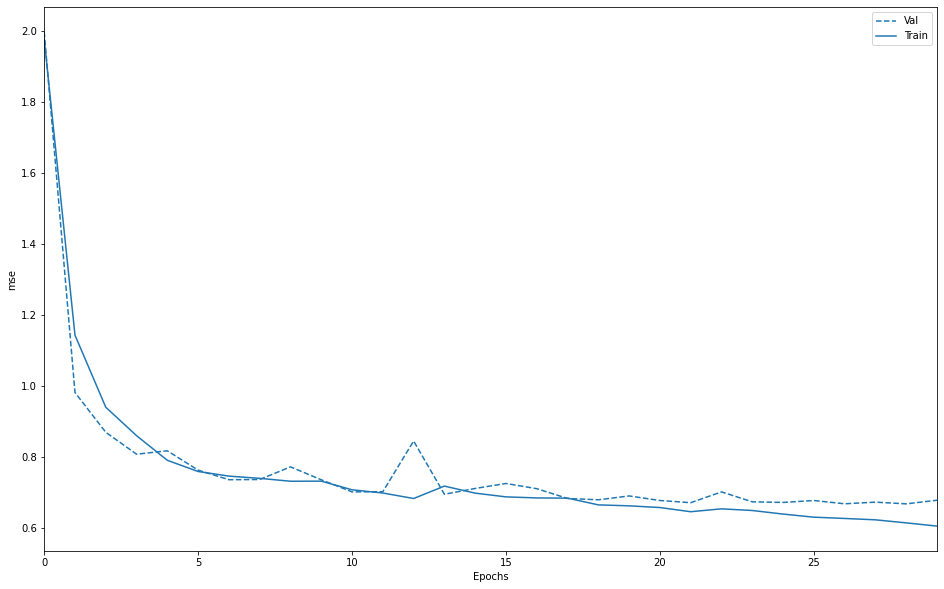

In [ ]:
plt.figure(figsize=(16,10))
plt.xlabel('Epochs')
plt.ylabel("mse")
val = plt.plot(history.epoch, history.history['val_'+'loss'],
                   '--', label='Val')
plt.plot(history.epoch, history.history["loss"], color=val[0].get_color(),
             label='Train')
plt.legend()
plt.xlim([0, max(history.epoch)])
#plt.ylim([0,0.02])
plt.savefig('/content/drive/MyDrive/Colorization/graphs/Many_classes_15_epoch_18946_samples.png')

# Эксперименты

In [ ]:
import zipfile
import os
from PIL import Image
import numpy as np 
import matplotlib.pyplot as plt
import cv2

#скачиваем и распаковываем .zip файл с изображениями, делать 1 раз
#z = zipfile.ZipFile('/content/drive/MyDrive/Colorization/zip/traain.zip', 'r')
#img = z.extractall()

x_set = []

#путь к папке с распакованными изображениями
path = '/content/traain'
fileList = os.listdir(path)
j = 0
for i in fileList:
   file_ = cv2.imread(('/content/traain/' + i))
   file_ = cv2.cvtColor(file_, cv2.COLOR_BGR2RGB)
   file_ = np.array(file_, dtype=float)
   image = Image.fromarray(np.uint8(file_)).resize((128, 128))
   image = np.array(image, dtype=float)
   if image.shape!=(128,128,3):
      print('ЧБ')
   else:
      lab = rgb2lab(1.2/255*image)
      x_set.append(lab)
      j=j+1
   if j%100 == 0 or j == 50018 or j == 50019:
      print(j)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
1850

In [ ]:
z = zipfile.ZipFile('/content/drive/MyDrive/Colorization/zip/test.zip', 'r')
img = z.extractall()
path = '/content/test'
fileList = os.listdir(path)
for i in fileList:
   file_ = cv2.imread(('/content/test/' + i))
   file_ = cv2.cvtColor(file_, cv2.COLOR_BGR2RGB)
   file_ = np.array(file_, dtype=float)
   image = Image.fromarray(np.uint8(file_)).resize((128, 128))
   image = np.array(image, dtype=float)
   if image.shape!=(128,128,3):
      print('ЧБ')
   else:
      lab = rgb2lab(1.2/255*image)
      x_set.append(lab)
      j=j+1
   if j%100 == 0 or j == 50018 or j == 50019:
      print(j)

In [ ]:
a = np.array(x_set)
np.random.shuffle(a)
print(type(a))
print(a.shape)

In [ ]:
#Узнаем среднее значение и стандартное отклонение каждого канала, сначала переведем в Lab
mean_L = np.mean(a[:,:,:,0])
mean_a = np.mean(a[:,:,:,1])
mean_b = np.mean(a[:,:,:,2])
std_L = np.std(a[:,:,:,0])
std_a = np.std(a[:,:,:,1])
std_b = np.std(a[:,:,:,2])

In [ ]:
print('mean_L =', mean_L)
print('mean_a =', mean_a)
print('mean_b =', mean_b)
print('std_L =', std_L)
print('std_a =', std_a)
print('std_b =', std_b)

In [ ]:
#по отдельности сделать это

import os
import zipfile
from PIL import Image 

newzip = zipfile.ZipFile('/content/drive/MyDrive/Colorization/zip/traaain.zip', 'w')
for i in range(2153):
    picture = Image.fromarray(a[i], 'RGB')
    picture = picture.save(str(i+1) + ".jpg")
    newzip.write(str(i+1) + ".jpg") #добавляем файл в архив

newzip.close() #закрываем архив